## Data Demo

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from imports import *

In [4]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *

In [5]:
# overall imports
import importlib
import data

# data load
#importlib.reload(data.data_load)
#importlib.reload(data.data_viz)

from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

[Sims](#sims)

### HCP Connectivity Data

#### fMRI

(114, 114)


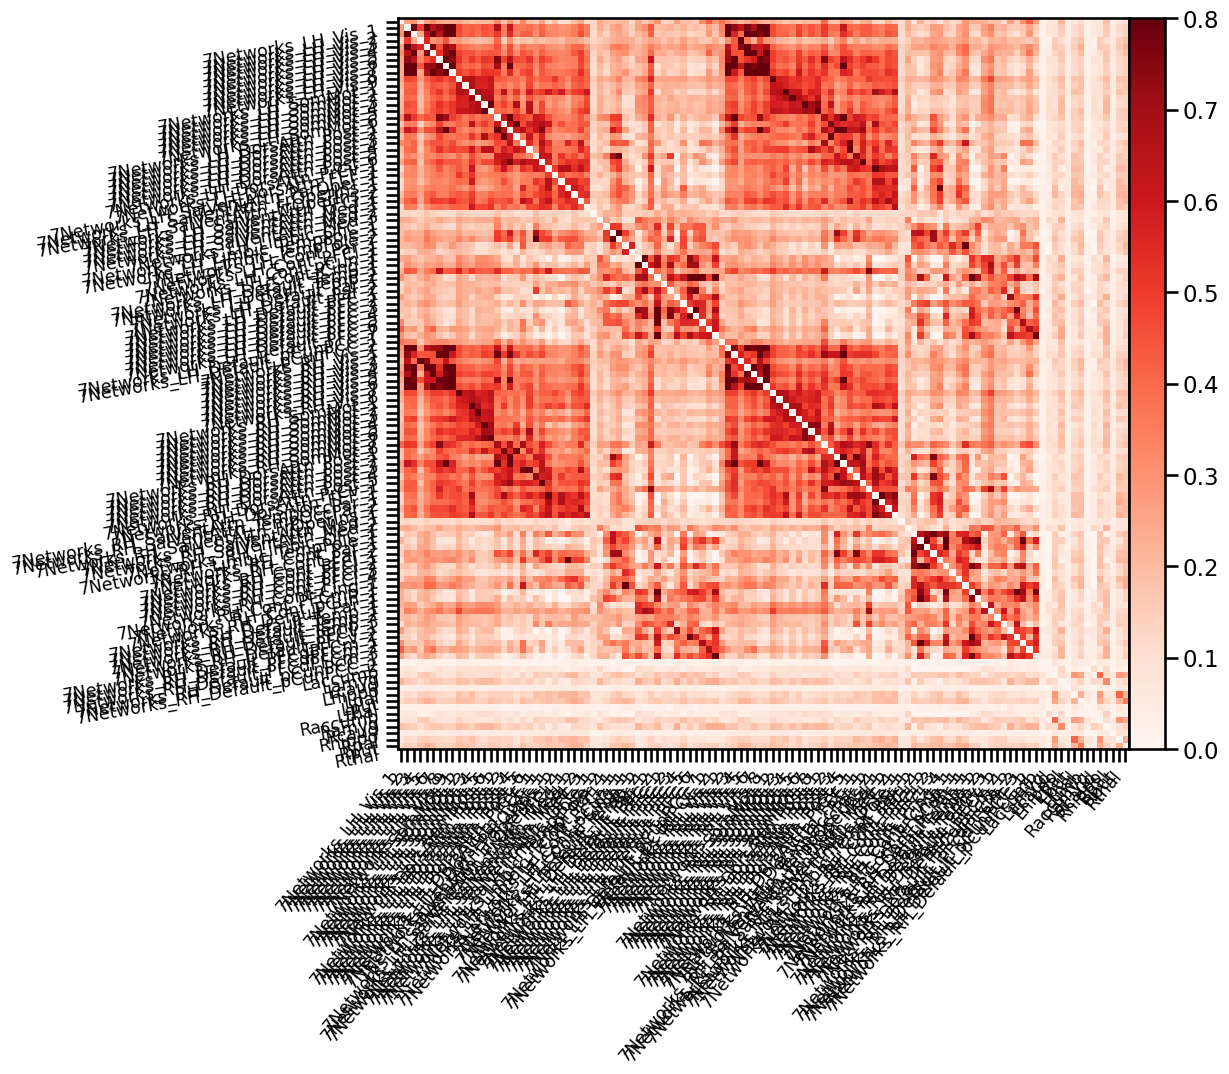

In [110]:
fc_combined_mat_schaef_100, fc_combined_labels_schaef_100 = load_fc_as_one(parcellation='schaefer_100')
print(fc_combined_mat_schaef_100.shape)
fc_all_schaef = plotting.plot_matrix(fc_combined_mat_schaef_100, figure=(9, 9), labels=fc_combined_labels_schaef_100, vmax=0.8, vmin=0, cmap='Reds')

In [111]:
print(fc_combined_labels_schaef_100)
print(fc_combined_mat_schaef_100)
Y_fc = fc_combined_mat_schaef_100

['7Networks_LH_Vis_1' '7Networks_LH_Vis_2' '7Networks_LH_Vis_3'
 '7Networks_LH_Vis_4' '7Networks_LH_Vis_5' '7Networks_LH_Vis_6'
 '7Networks_LH_Vis_7' '7Networks_LH_Vis_8' '7Networks_LH_Vis_9'
 '7Networks_LH_SomMot_1' '7Networks_LH_SomMot_2' '7Networks_LH_SomMot_3'
 '7Networks_LH_SomMot_4' '7Networks_LH_SomMot_5' '7Networks_LH_SomMot_6'
 '7Networks_LH_DorsAttn_Post_1' '7Networks_LH_DorsAttn_Post_2'
 '7Networks_LH_DorsAttn_Post_3' '7Networks_LH_DorsAttn_Post_4'
 '7Networks_LH_DorsAttn_Post_5' '7Networks_LH_DorsAttn_Post_6'
 '7Networks_LH_DorsAttn_PrCv_1' '7Networks_LH_DorsAttn_FEF_1'
 '7Networks_LH_SalVentAttn_ParOper_1'
 '7Networks_LH_SalVentAttn_FrOperIns_1'
 '7Networks_LH_SalVentAttn_FrOperIns_2' '7Networks_LH_SalVentAttn_PFCl_1'
 '7Networks_LH_SalVentAttn_Med_1' '7Networks_LH_SalVentAttn_Med_2'
 '7Networks_LH_SalVentAttn_Med_3' '7Networks_LH_Limbic_OFC_1'
 '7Networks_LH_Limbic_TempPole_1' '7Networks_LH_Limbic_TempPole_2'
 '7Networks_LH_Cont_Par_1' '7Networks_LH_Cont_PFCl_1'
 '7Networ

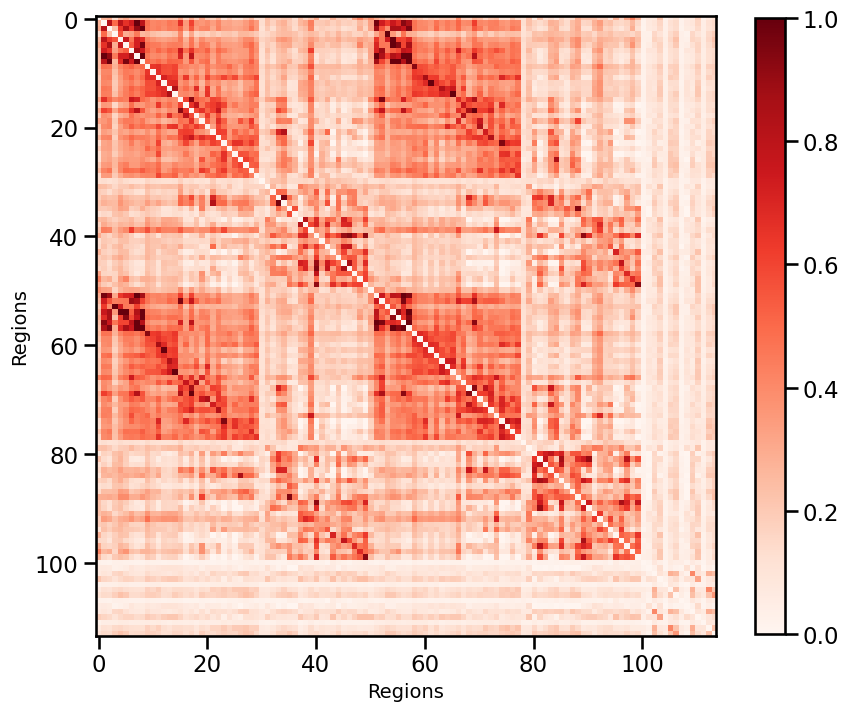

In [141]:
Y_fc = load_connectome(measure='FC', omit_subcortical=False)
plot_connectome(Y_fc)

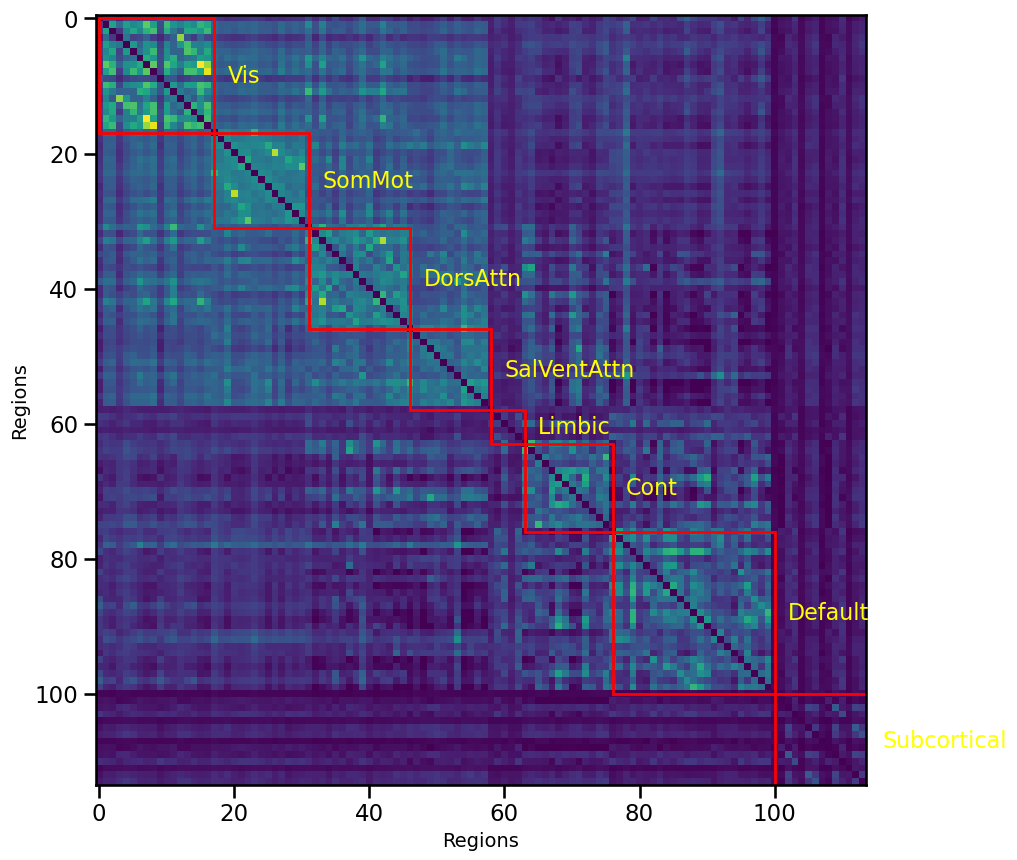

In [142]:
plot_connectome_with_labels(Y_fc, fc_combined_labels_schaef_100)


#### Louvain community detection

Graph with 114 nodes and 6441 edges
[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 29, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 101, 108}, {66, 68, 69, 71, 72, 73, 74, 75, 76, 77, 15, 80, 17, 19, 83, 21, 22, 23, 24, 25, 26, 27, 28, 84, 87, 33, 34, 39}, {0, 30, 31, 32, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 78, 79, 81, 82, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113}]


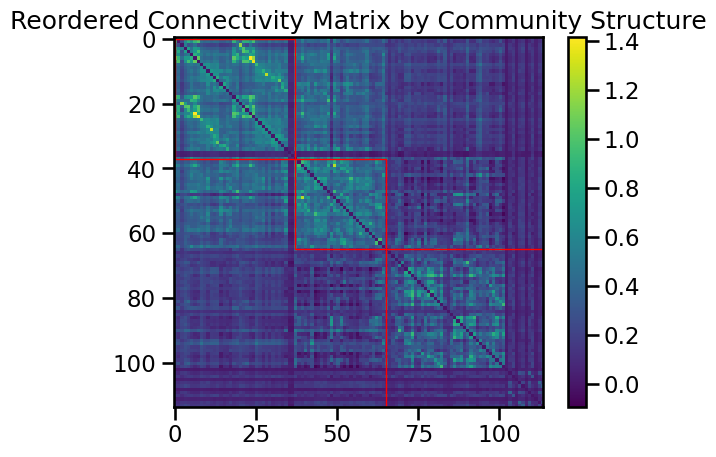

In [143]:
Y = load_connectome()
connectome_net = nx.Graph(incoming_graph_data=Y)
print(connectome_net)

# resolution parameter should be maximized until an inner train is infeasible/impractical to evaluate (1.1 could technically work)
communities = nx.community.louvain_communities(connectome_net, seed=3, resolution=1.02)
print(communities)

# Create a new ordering of nodes based on louvain community detection
new_order = []
for community in communities:
    new_order.extend(community)

# Map the original indices to the new ordering
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(new_order)}

# Reorder the matrix
Y_reordered = Y[np.ix_(new_order, new_order)]

# Visualize the reordered matrix
fig, ax = plt.subplots()
cax = ax.imshow(Y_reordered, cmap='viridis')

# Add colorbar
plt.colorbar(cax)

# Add red boxes around communities
start = 0
for community in communities:
    size = len(community)
    rect = patches.Rectangle((start, start), size, size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    start += size

plt.title('Reordered Connectivity Matrix by Community Structure')
plt.show()

#### HCP connectomes in replication dataset space

#### GTEx-space connectome

In [144]:
gtex_transcriptome = load_transcriptome(dataset='GTEx')
gtex_connectome = load_connectome(dataset='GTEx')

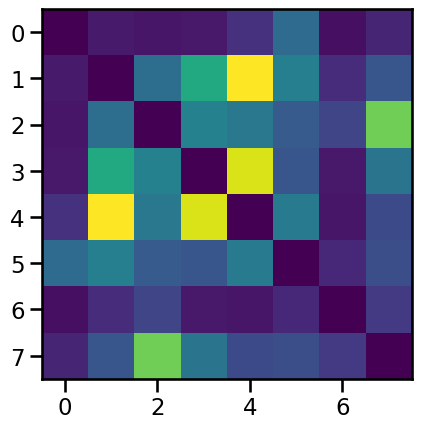

In [145]:
plt.imshow(gtex_connectome)

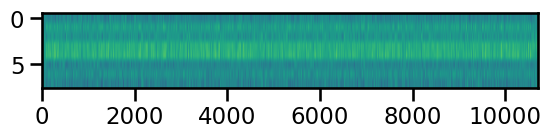

In [146]:
plt.imshow(gtex_transcriptome, aspect=200)

##### UTSW-space connectome

In [147]:
utsw_transcriptome = load_transcriptome(dataset='UTSW')
utsw_connectome = load_connectome(dataset='UTSW')

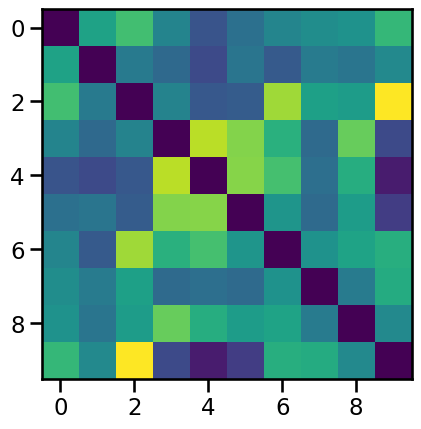

In [148]:
plt.imshow(utsw_connectome)

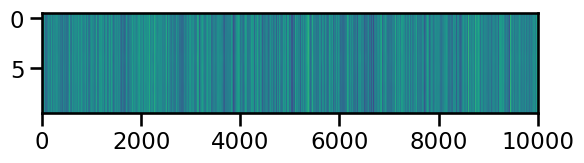

In [149]:
plt.imshow(utsw_transcriptome, aspect=200)

### AHBA gene data

In [150]:
genes = fetch_ahba()
genes

,label,A1BG,A1BG-AS1,AAAS,AACS,AADACL3,AADAT,AAED1,AAK1,AAMDC,...,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDA,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,L_bankssts,0.468854,0.700170,0.505789,0.764127,0.374206,0.658622,0.345665,0.511831,0.424702,...,0.578213,0.539968,0.542518,0.580108,0.436774,0.342712,0.690473,0.700179,0.533907,0.482430
1,L_caudalanteriorcingulate,0.606901,0.560731,0.459692,0.673249,0.424793,0.709927,0.441996,0.366110,0.603905,...,0.736780,0.471864,0.441377,0.406806,0.458666,0.486808,0.624359,0.496063,0.427907,0.510274
2,L_caudalmiddlefrontal,0.512080,0.609772,0.516944,0.791223,0.368258,0.591441,0.440311,0.520090,0.494193,...,0.568923,0.522407,0.595659,0.471493,0.366045,0.356483,0.689424,0.731162,0.367931,0.461228
3,L_cuneus,0.340848,0.570180,0.677448,0.750356,0.442332,0.569819,0.364639,0.666202,0.429725,...,0.328457,0.589241,0.562006,0.451543,0.403732,0.370707,0.646500,0.859074,0.568544,0.369236
4,L_entorhinal,0.663801,0.549562,0.395052,0.721829,0.449548,0.588481,0.576347,0.347882,0.548371,...,0.702060,0.479673,0.546094,0.691197,0.360518,0.526293,0.706851,0.333083,0.345136,0.557094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Rcaud,0.619848,0.318972,0.498983,0.271222,0.555309,0.500222,0.663142,0.330626,0.720306,...,0.812634,0.332516,0.302927,0.370860,0.751410,0.699088,0.275580,0.224110,0.339080,0.420971
78,Rhippo,0.377399,0.274101,0.347923,0.523755,0.718340,0.228699,0.565169,0.739631,0.258704,...,0.328818,0.359226,0.368190,0.651293,0.645399,0.554279,0.376828,0.285925,0.485843,0.412266
79,Rpal,0.800714,0.220463,0.635593,0.197948,0.548496,0.624486,0.664744,0.221901,0.937931,...,0.482249,0.644349,0.273982,0.329791,0.568571,0.801305,0.258434,0.430613,0.565564,0.785757
80,Rput,0.697285,0.447848,0.514870,0.367506,0.406484,0.595085,0.469804,0.212579,0.670761,...,0.794397,0.419572,0.480628,0.464933,0.689909,0.636104,0.320400,0.349777,0.534618,0.601170


In [151]:
X = load_transcriptome(omit_subcortical=False)

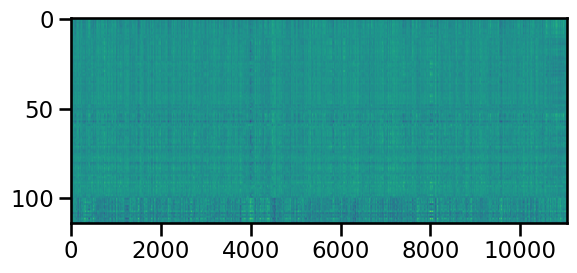

In [152]:
plt.imshow(X, aspect=40)

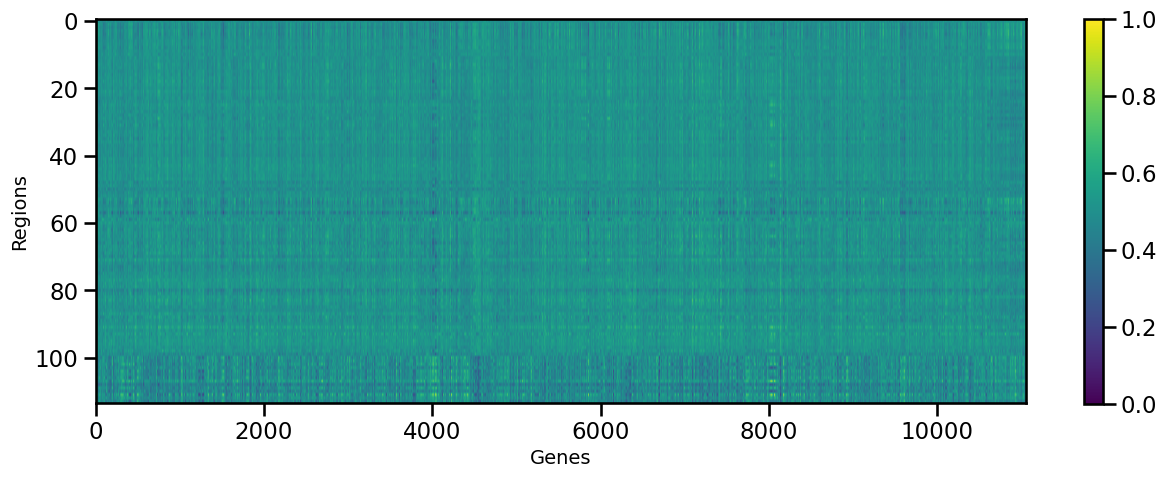

In [153]:
plot_transcriptome(X)

#### Visualize transcriptome-transcriptome spatial heatmap

(114, 114)


<Axes: >

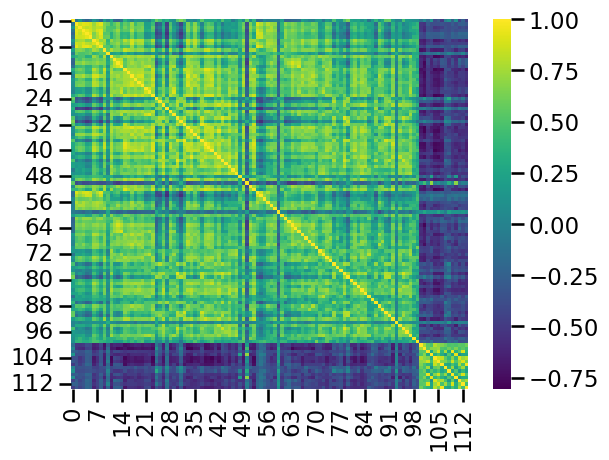

In [154]:
# compute region-region correlations for schaefer 100 parcellation
# label is considered our variables and each gene is an observation 
# this will result in a 114x114 regional gene correlation matrix of AHBA
X_df = pd.DataFrame(X)

schaefer_genes_region_corr = X_df.T.corr(method = 'pearson', numeric_only = False)
print(schaefer_genes_region_corr.shape)
sns.heatmap(schaefer_genes_region_corr, cmap = 'viridis')

<Axes: >

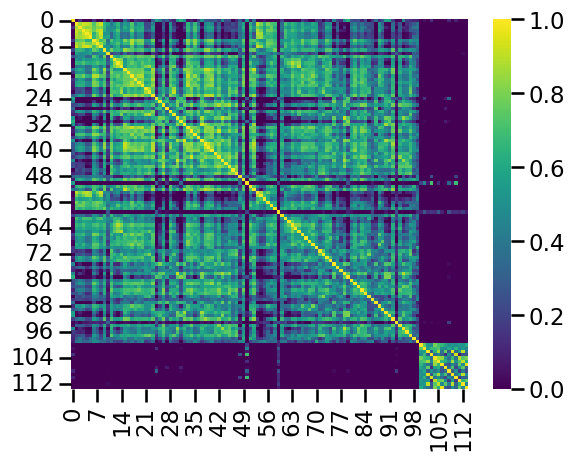

In [155]:
# Plot the heatmap with the updated correlation matrix
sns.heatmap(schaefer_genes_region_corr, cmap='viridis', vmin=0)

#### Correlate transcriptome-fMRI

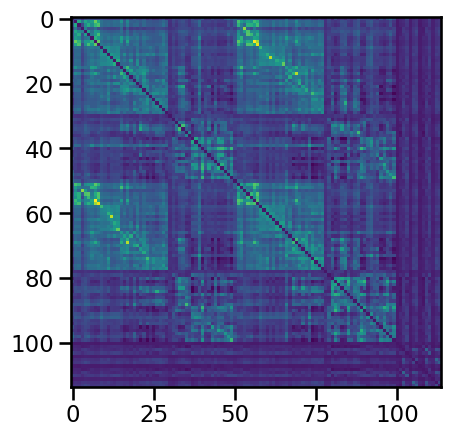

In [156]:
plt.imshow(Y_fc)

In [157]:
# Replace negative values with 0 in the correlation matrix
# schaefer_genes_region_corr[schaefer_genes_region_corr < 0] = 0

# Flatten both matrices to compute the total correlation
schaefer_genes_region_corr_flat = schaefer_genes_region_corr.values.flatten()  # if it's a pandas DataFrame
Y_flat = Y.flatten()  # Assuming Y is a numpy array

# Compute Pearson correlation between the flattened matrices
total_correlation = np.corrcoef(schaefer_genes_region_corr_flat, Y_flat)[0, 1]

# Print the total correlation value
print(f"Total Pearson correlation between the thresholded heatmap and true connectome: {total_correlation}")


Total Pearson correlation between the thresholded heatmap and true connectome: 0.44635179977766054


### DTI

(114, 114)


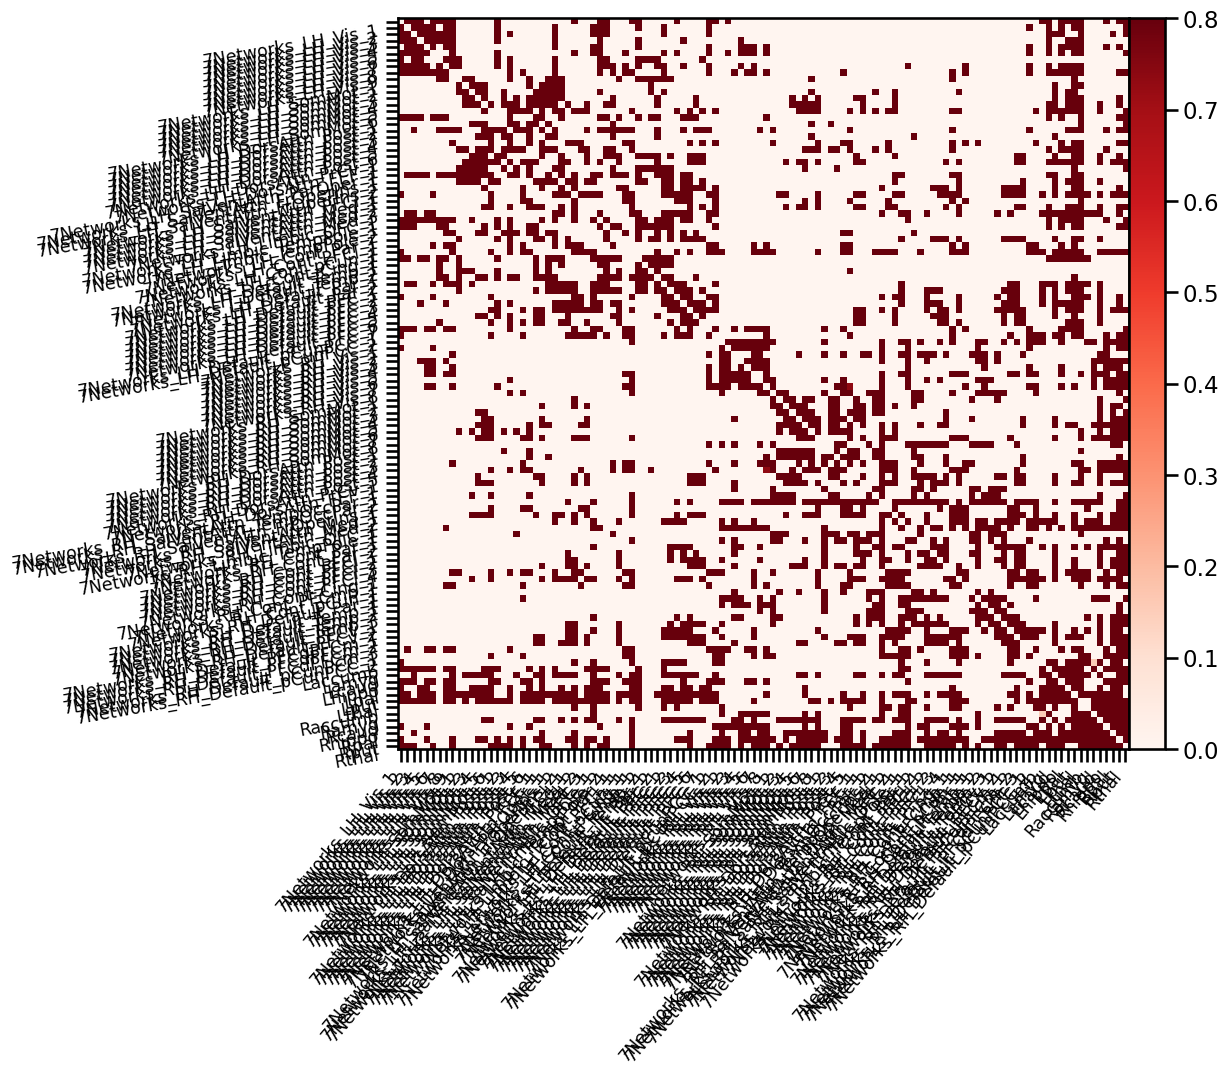

In [158]:
sc_combined_mat_schaef_100, sc_combined_labels_schaef_100 = load_sc_as_one(parcellation='schaefer_100')
print(sc_combined_mat_schaef_100.shape)
sc_all_schaef = plotting.plot_matrix(sc_combined_mat_schaef_100, figure=(9, 9), labels=sc_combined_labels_schaef_100, vmax=0.8, vmin=0, cmap='Reds')

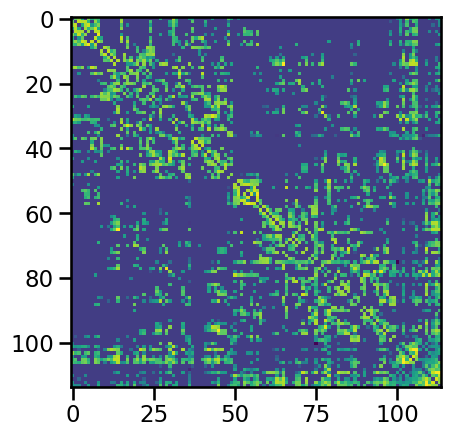

In [159]:
Y_sc = load_connectome(measure='SC', omit_subcortical=False)
plt.imshow(Y_sc)

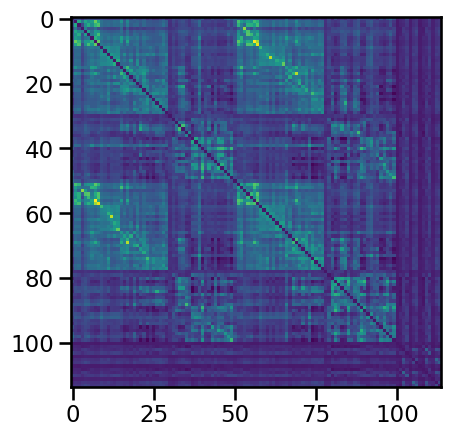

In [160]:
plt.imshow(Y_fc)

#### Correlate DTI-fMRI

In [161]:
# Flatten both matrices to compute the total correlation

Y_sc = Y_sc.flatten()  # if it's a pandas DataFrame
Y_flat = Y_fc.flatten()  # Assuming Y is a numpy array

# Compute Pearson correlation between the flattened matrices
total_correlation = np.corrcoef(Y_sc, Y_flat)[0, 1]

# Print the total correlation value
print(f"Total Pearson correlation between the thresholded heatmap and true connectome: {total_correlation}")


Total Pearson correlation between the thresholded heatmap and true connectome: 0.17274458597319897


### Distance

In [162]:
# Extract the coordinates from the DataFrame
coordinates = load_coords()

# Compute pairwise Euclidean distances
distance = squareform(pdist(coordinates, metric='euclidean'))

In [1]:
plt.imshow(1/distance)

NameError: name 'plt' is not defined

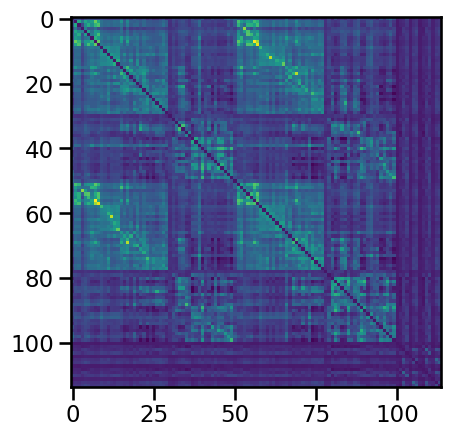

In [164]:
plt.imshow(Y_fc)

#### Correlate distance-fMRI

In [165]:
# Flatten both matrices to compute the total correlation
distance = distance.flatten()  # if it's a pandas DataFrame
Y_flat = Y_fc.flatten()  # Assuming Y is a numpy array

# Compute Pearson correlation between the flattened matrices
total_correlation = np.corrcoef(distance, Y_flat)[0, 1]

# Print the total correlation value
print(f"Total Pearson correlation between the thresholded heatmap and true connectome: {total_correlation}")


Total Pearson correlation between the thresholded heatmap and true connectome: -0.0839242094073291


In [166]:
# coordinates can serve as an X matrix e.g.

In [167]:
# assign macro region and fetch euclidean...